<div style="border:solid blue 2px; padding: 20px">

   Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Мне предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Первичный анализ данных

In [ ]:
# pip install catboost

Импортируем нужные библиотеки:

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.svm import LinearSVR
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
RANDOM_STATE = 100423

Каждый датасет сохраняем в соответствующую переменную:

In [ ]:
try:
  # данные об электродах
  data_arc = pd.read_csv('')

  # данные о подаче сыпучих материалов (объём)
  data_bulk = pd.read_csv('')

  # данные о подаче сыпучих материалов (время)
  data_bulk_time = pd.read_csv('')

  # данные о продувке сплава газом
  data_gas = pd.read_csv('')

  # результаты измерения температуры
  data_temp = pd.read_csv('')

  # данные о проволочных материалах (объём)
  data_wire = pd.read_csv('')

  # данные о проволочных материалах (время)
  data_wire_time = pd.read_csv('')

except:
  from google.colab import drive
  drive.mount('/content/drive')
  data_arc = pd.read_csv('')
  data_bulk = pd.read_csv('')
  data_bulk_time = pd.read_csv('')
  data_gas = pd.read_csv('')
  data_temp = pd.read_csv('')
  data_wire = pd.read_csv('')
  data_wire_time = pd.read_csv('')

### Изучим общую информацию

Создадим функцию, которая на вход получает название таблицы и датасет, а выдаёт общую информацию, первые 5 строк и описательную статистику данных.

In [ ]:
def info_describe(name_table, data):
    print(name_table)
    print('--' * 20)
    print(data.info()) # общая информация о датасете
    display(data.head())
    display(data.describe()) # описательная статистика данных

In [ ]:
info_describe('Данные об электродах', data_arc)

Данные об электродах
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [ ]:
info_describe('Данные о подаче сыпучих материалов (объём)', data_bulk)

Данные о подаче сыпучих материалов (объём)
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [ ]:
info_describe('Данные о подаче сыпучих материалов (время)', data_bulk_time)

Данные о подаче сыпучих материалов (время)
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [ ]:
info_describe('Данные о продувке сплава газом', data_gas)

Данные о продувке сплава газом
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [ ]:
info_describe('Результаты измерения температуры', data_temp)

Результаты измерения температуры
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [ ]:
info_describe('Данные о проволочных материалах (объём)', data_wire)

Данные о проволочных материалах (объём)
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [ ]:
info_describe('Данные о проволочных материалах (время)', data_wire_time)

Данные о проволочных материалах (время)
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Всего мы имеем данные о 3.241 партии стали. В каждой таблице есть небольшое количество партий (от 2 в таблице с газом до 160 в таблице о проволочных материалах), информация о которых отсутствует. 

В **данных об электродах** указаны начало и конец нагрева дугой, активная и реактивная мощности. Исходя из описательной статистики можно увидеть выбросы в реактивной мощности.

В **данных о подаче сыпучих материалов** содержится информация о 15 видах примесей (Bulk 1 - Bulk 15). В большинстве случаев добавляются примеси под номерами 12, 14 и 15; в треть партий примеси 3 и 4. Bulk 8 добавлялся в состав один раз, нужно узнать можно ли его исключить при обучении модели. Bulk 12 имеет выброс, максимальное значение 1849 является аномальным.

В **данных о продувке сплава газом** минимальное значение инертного газа, которым продувают сплав составляет 0.008399, необходимо уточнить у заказчика допустимы ли такие низкие значения.

**Результаты измерения температуры.** Среднее значение температуры стали при её обработке 1.591 градус (Фаренгейта?). Пропущенные значения температур (их 2091) нужно выяснить как корректнее обработать.

**Данные о проволочных материалах** Выделено 9 видов проволочных материалов, добавляемых при легировании стали. Wire 1 добавляется почти в каждой партии объёмом от 1,92 до 330. Wire 2 добавляется в три раза реже, остальные шесть - практически единичные случаи.

Тип времени в таблице data_bulk_time и data_wire_time нужно изменить на datetime.

In [ ]:
# изменим тип данных времени в data_bulk_time
for b in [column for column in data_bulk_time.drop('key', axis=1)]:
    data_bulk_time[b] = pd.to_datetime(data_bulk_time[b], format='%Y-%m-%d %H:%M:%S')

In [ ]:
# изменим тип данных времени в data_wire_time
for w in [column for column in data_wire_time.drop('key', axis=1)]:
    data_wire_time[w] = pd.to_datetime(data_wire_time[w], format='%Y-%m-%d %H:%M:%S')

### Проверка на выбросы

**Построим графики ящик с усами, чтобы увидеть какие аномальные значения имеются.**

В реактивной мощности прежде удалим выброс равный -715.

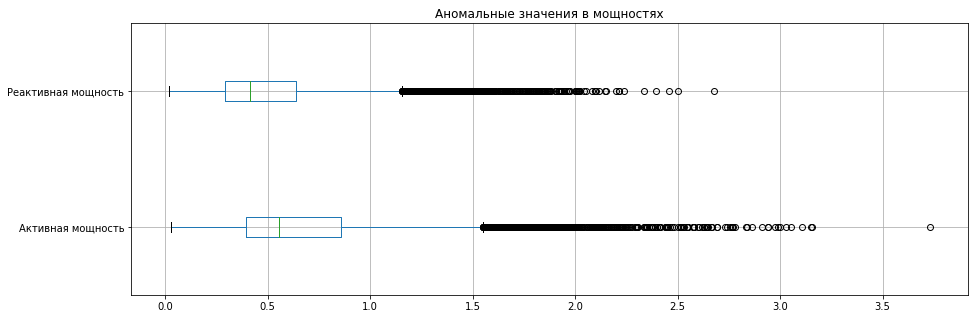

In [ ]:
# исследуем выбросы в мощностях
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]
data_arc.boxplot(column=['Активная мощность', 'Реактивная мощность'], 
                 vert=False, figsize=(15,5))
plt.title('Аномальные значения в мощностях');

Есть выбросы и там и там. Но такие мощности были необходимы для производстенного процесса, поэтому избавляться от них некорректно.

Теперь исследуем выбросы в объёмах сыпучих продуктов.

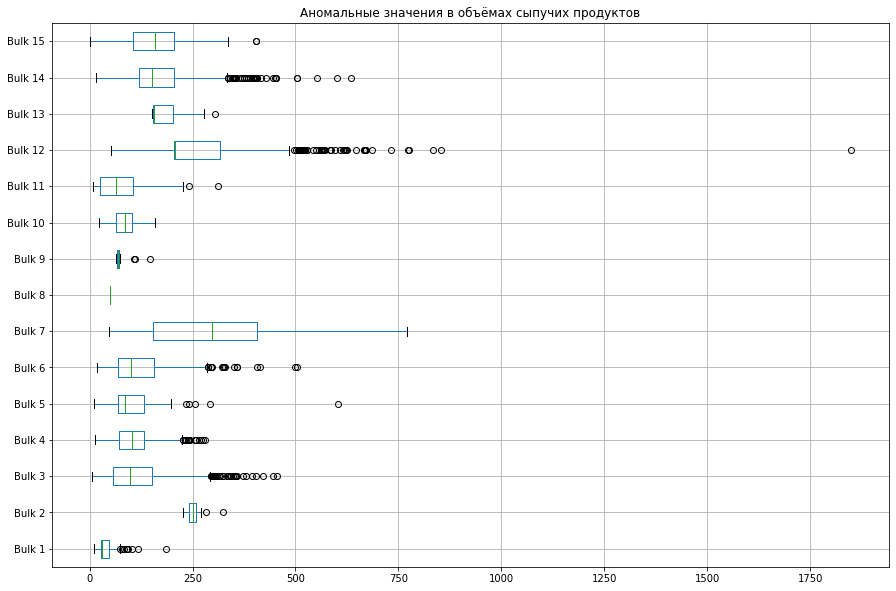

In [ ]:
data_bulk.drop('key', axis=1).boxplot(vert=False, figsize=(15,10));
plt.title('Аномальные значения в объёмах сыпучих продуктов');

Здесь есть одно аномальное значение, удалим выброс в Bulk 12 = 1849.

In [ ]:
data_bulk = data_bulk[data_bulk['Bulk 12'] != 1849]

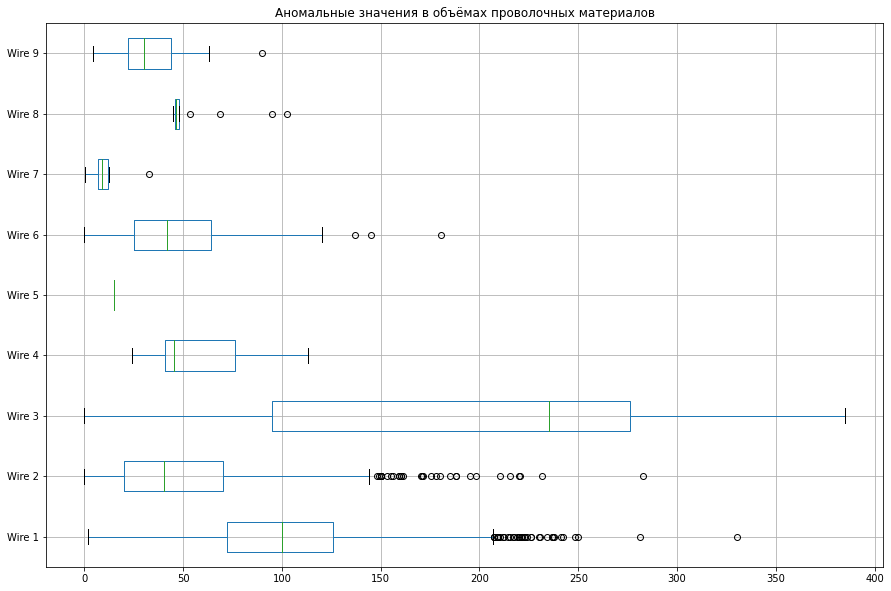

In [ ]:
# исследуем выбросы в объёмах проволочных материалов
data_wire.drop('key', axis=1).boxplot(vert=False, figsize=(15,10));
plt.title('Аномальные значения в объёмах проволочных материалов');

Выбросы имеются почти в каждом случае, как у сыпучих продуктов, так и у проволочных материалов. Нужно узнать у заказчика требуется ли очистка от таких высоких значений легирующихих добавок или они являются необходимыми при очистки стали.

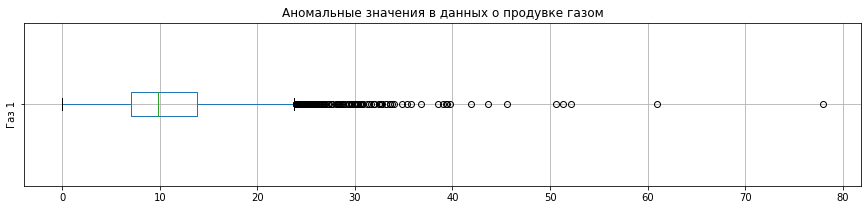

In [ ]:
# исследуем выбросы в данных о продувке газом
data_gas.boxplot(column='Газ 1', rot=90, vert=False, figsize=(15,3));
plt.title('Аномальные значения в данных о продувке газом');

От двух строк со значениями выше 60 есть смысл избавиться, чтобы не исказить модель при обучении.

In [ ]:
data_gas = data_gas[data_gas['Газ 1'] < 60]

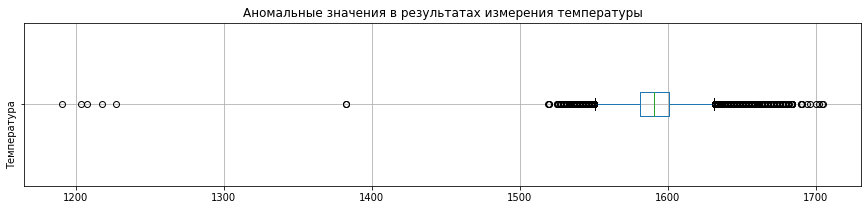

In [ ]:
# исследуем выбросы в результатах измерения температуры
data_temp.boxplot(column='Температура', rot=90, vert=False, figsize=(15,3));
plt.title('Аномальные значения в результатах измерения температуры');

Температура плавления стали выше 1400 градусов. Поэтому строки с температурой ниже 1400 градусов можно удалить, их всего 5 и это явные аномалии.

In [ ]:
data_temp = data_temp.loc[(data_temp['Температура'] > 1400) | # делаем срез по температуре выше 1400
                          (data_temp['Температура'].isna())]  # и оставляем пропущенные значения

Я очистила данные от явных аномальных значений - высокие активные и реактивные мощности, большая подача газа и температура выше 1400 градусов. Оставила зашкаливающие объёмы подачи добавок при легировании стали до уточнения вопроса у заказчика.

### Нормальность распределения

После удаления выбросов посмотрим на распределение значений.

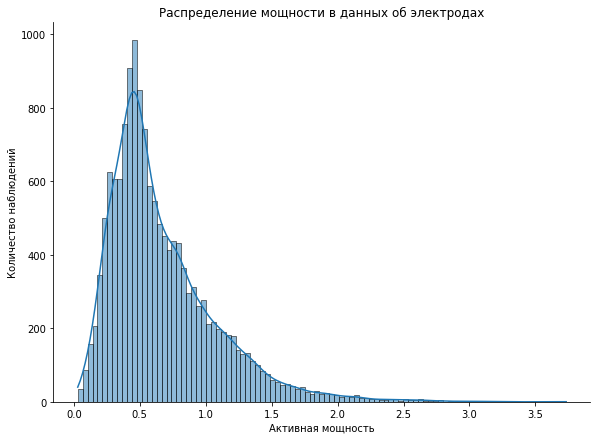

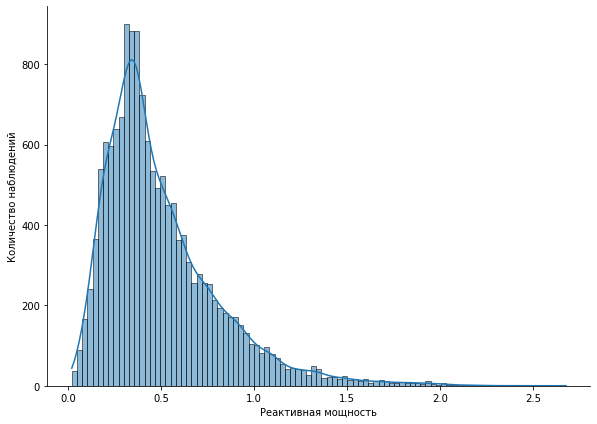

In [ ]:
sns.displot(data_arc['Активная мощность'], kde=True,  height=6, aspect=1.4)
plt.xlabel('Активная мощность')
plt.ylabel('Количество наблюдений')
plt.title(('Распределение мощности в данных об электродах'))

sns.displot(data_arc['Реактивная мощность'], kde=True,  height=6, aspect=1.4) 
plt.xlabel('Реактивная мощность')
plt.ylabel('Количество наблюдений')

plt.show()

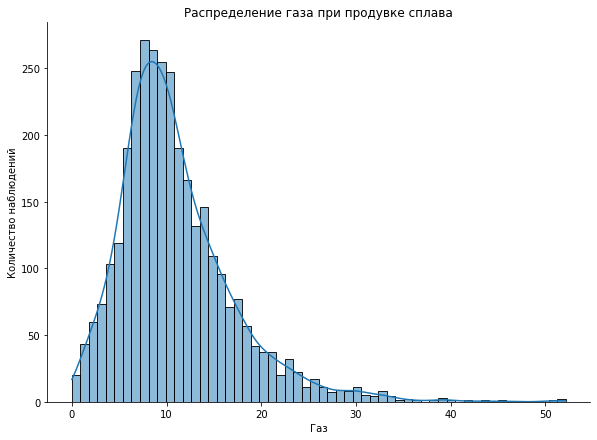

In [ ]:
sns.displot(data_gas['Газ 1'], kde=True,  height=6, aspect=1.4)
plt.xlabel('Газ')
plt.ylabel('Количество наблюдений')
plt.title(('Распределение газа при продувке сплава'))

plt.show()

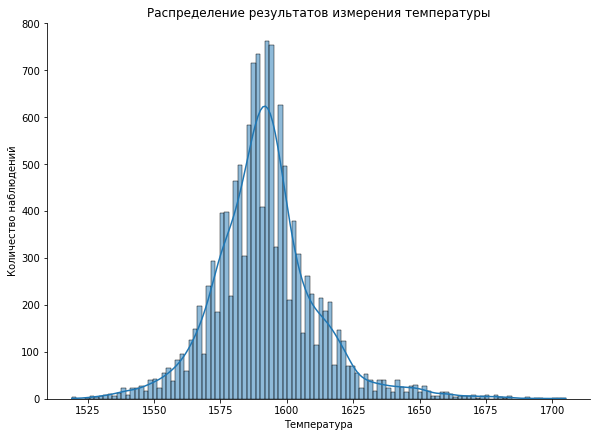

In [ ]:
sns.displot(data_temp['Температура'], kde=True,  height=6, aspect=1.4)
plt.xlabel('Температура')
plt.ylabel('Количество наблюдений')
plt.title(('Распределение результатов измерения температуры'))

plt.show()

Мощности имеют отклонение вправо от нормального распределения, газ также, но это отклонение менее выражено. Распределение результатов измерения температур (наш целевой признак) стремится к нормальному. Температура стали при обработке в диапазоне 1525 - 1700 градусов.

### Обработка пропусков

Пропуски в объёмах сыпучих и проволочных материалах заменим нулями, так как они говорят о том, что данный вид материалов не применялся при легировании стали в данной партии.

In [ ]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)

После консультации было принято решение избавиться от всех объектов, содержащих пропуски, так как наша целевая это как раз последний замер температуры.

In [ ]:
data_temp = data_temp.dropna()

## План работы

<div style="border:solid blue 2px; padding: 20px">

   * Провести исследовательский анализ данных
   * Подготовить данные для обучения модели (пропуски, выбросы)
   * Удалить данные, которые не информативны (возможно, добавки какие добавлялись менее чем в 5% случаев)
   * Объединить таблицы
   * Разделить данные на выборки (обучающая, тестовая)
   * Проверка на мультиколлинеарность
   * Выбрать модели и провести обучение
   * Проверить лучшую модель на адекватность
   * Анализ важности факторов у модели-победителя

## Вопросы по моделируемому процессу для бизнеса

<div style="border:solid blue 2px; padding: 20px">

   1. Имеются легирующие добавки, которые добавляются в состав в менее чем 5% случаев, пара из них вообще по одному разу (Bulk8, Wire 5). Можно ли исключить их в дальнейшем исследовании?
    
   2. Минимальное значение инертного газа, которым продувают сплав составляет 0.008399, это допустимые значения?
    
   3. С чем могут быть связаны пропуски в замерах темератур? Первые замеры есть, а вторые и последующие в 2091 партии отсутсвуют.
    
   4. Требуется ли очистка от высоких значений легирующихих добавок или они являются необходимыми при очистки стали? Например, Wire 1 объёмом больше 210 или Bulk 12 больше 500.

 ## Подготовка данных к обучению

### Целевой признак (target)

Для начала нужно выделить нашу целевую - температура на выходе. Но прежде нужно избавиться от тех партий, в которых есть лишь один замер температуры. Для этого создадим новую таблицу, в которой будут сначала сгруппированы партии по ключу, суммировано количество замеров, а затем удалены те строки, в которых значение в столбце "Температура" равно 1.

In [ ]:
res = data_temp.groupby('key', as_index=False).count()[
    (data_temp.groupby('key', as_index=False).count()['Температура']==1)==False]

Следующим шагом создаём отфильтрованную таблицу, в которые входят только те ключи, которые содержатся в полученной выше таблице.

In [ ]:
new_data_temp = data_temp[data_temp['key'].isin(res['key'])]
new_data_temp.shape

(12259, 3)

Теперь можем выделить нашу целевую переменную - последнняя измеряемая температура в каждой партии.

In [ ]:
target = new_data_temp.groupby('key').agg({'Температура':'last'})
print('Размер таблицы с целевой переменной', target.shape)
target.head()

Размер таблицы с целевой переменной (2475, 1)


,Температура
key,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0


### Признаки (features)

Первый замер температуры будет одним из наших признаков. Сохраним их в переменной first_temp.

In [ ]:
first_temp = new_data_temp.groupby('key').agg({'Температура':'first'}).rename(
    columns={'Температура': 'Температура 1'})

In [ ]:
target = target[target['Температура'] != first_temp['Температура 1']]
target[:5]

,Температура
key,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0


Теперь создадим фичи для обучения моделей. Это будет:
* первый замер температуры;
* объём подачи газа по партии;
* присадки (предварительно редкие объединим в отдельные группы);
* полная мощность (которую получим из активной и реактивной мощностей).

Первый признак будем присоединять к таблице first_temp методом join по столбцу key, чтобы найти из таблицы с газом те партии, которые есть в индексах таблицы first_temp. Все остальные признаки будем присоединять методом merge  по тому эе столбцу. Все присоединения выполняем по типу слияния inner.

После этого нужно в таргете сделать срез, удалив партии не вошедшие в итоговые фичи ввиду того, что в некоторых таблицах есть пропуски.

In [ ]:
# соединяем газ и температуру
features = data_gas.join(first_temp, on='key', how='inner')
features[:3]

,key,Газ 1,Температура 1
0,1,29.749986,1571.0
1,2,12.555561,1581.0
2,3,28.554793,1596.0


Найдём полную мощность и присоединим её к таблице с газом и температурой.
Полная мощность рассчитывается по формуле:

$S = \sqrt(P^2 + Q^2), $ где 

$S$ - полная мощность,

$P$ - активная мощность,

$Q$ - реактивная мощность.

In [ ]:
features['Полная мощность'] = (data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2) ** 0.5
features[:3]

,key,Газ 1,Температура 1,Полная мощность
0,1,29.749986,1571.0,1.193639
1,2,12.555561,1581.0,0.959010
2,3,28.554793,1596.0,0.896038


Выполняем объединение тех редких сыпучих и проволочных материалов в столбец  "bulk_rare" и "wire_rare" соотв., которые использовались менее чем в 5% случаев.  Сыпучие это Bulk 2, 5, 7, 8, 9, 13. Проволочные - Wire 3, 4, 5, 6, 7, 8 , 9.

In [ ]:
# объёмы сыпучих материалов с объединением редких
bulk_rare = ['Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 13']
data_bulk['Bulk_rare'] = data_bulk[bulk_rare].sum(axis=1)
data_bulk[102:105]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk_rare
102,115,78.0,232.0,0.0,21.0,112.0,0.0,178.0,0.0,0.0,0.0,67.0,0.0,0.0,0.0,0.0,522.0
103,116,0.0,0.0,0.0,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,105.0,203.0,0.0
104,117,52.0,325.0,0.0,68.0,112.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,437.0


In [ ]:
# объёмы проволочных материалов с объединением редких
wire_rare = ['Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
data_wire['Wire_rare'] = data_wire[wire_rare].sum(axis=1)
data_wire[20:23]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire_rare
20,21,119.290081,98.367363,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
21,22,144.755523,99.910721,250.041794,0.0,0.0,0.0,0.0,0.0,0.0,250.041794
22,23,100.158234,114.907524,276.324066,0.0,0.0,0.0,0.0,0.0,0.0,276.324066


In [ ]:
# объединяем таблицы с добавками в одну, исключая те столбцы, которые мы объединили в редкие
bulk_wire = data_wire.drop(columns=data_wire[wire_rare]).merge(data_bulk.drop(columns=data_bulk[bulk_rare]),
                     on='key', how='inner') 

# обединяем все признаки, установив ключ партии индексом, как в таргете
features = (features.merge(bulk_wire, on='key', how='inner')).set_index('key')
features.head()

,Газ 1,Температура 1,Полная мощность,Wire 1,Wire 2,Wire_rare,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Bulk_rare
key,,,,,,,,,,,,,,,,
1,29.749986,1571.0,1.193639,60.059998,0.00000,0.0,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,0.0
2,12.555561,1581.0,0.959010,96.052315,0.00000,0.0,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,0.0
3,28.554793,1596.0,0.896038,91.160157,0.00000,0.0,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,0.0
4,18.841219,1601.0,1.970470,89.063515,0.00000,0.0,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,0.0
5,5.413692,1576.0,0.807239,89.238236,9.11456,0.0,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,0.0


In [ ]:
print('Размер таблицы с признаками:', features.shape)

Размер таблицы с признаками: (2327, 16)


Text(0.5, 1.0, 'Мультиколлинеарность признаков')

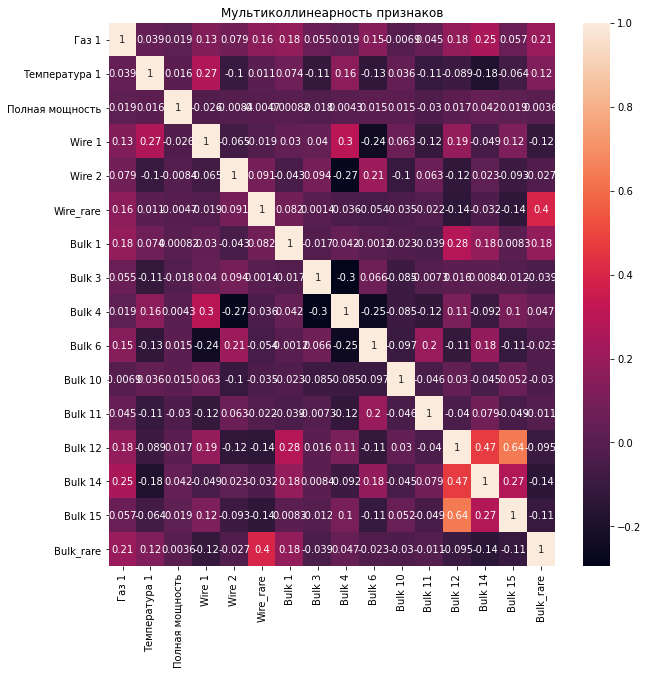

In [ ]:
# проверим признаки на мультиколлинеарность
plt.figure(figsize=(10, 10))
sns.heatmap(features.corr(), annot = True)
plt.title('Мультиколлинеарность признаков');

Высококоллерируемых признаков не обнаружено.

Партий, вошедших в итоговую таблицу с признаками меньше, чем партий с целевым значением. Отфильтруем target, оставив только партии из features.

In [ ]:
target = target[target.index.isin(features.index)]
features = features[features.index.isin(target.index)]
print(features.shape, target.shape)

(2290, 16) (2290, 1)


Длины таблиц с таргетом и с фичами равны. Разделим данные на обучающие и тестовые выборки.

### Разделение данных на выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                 features, target, test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
# проверим размеры выборок
print('Обучающая:', X_train.shape, y_train.shape)
print('Тестовая:', X_test.shape, y_test.shape)

Обучающая: (1717, 16) (1717, 1)
Тестовая: (573, 16) (573, 1)


In [ ]:
X_train.head()

,Газ 1,Температура 1,Полная мощность,Wire 1,Wire 2,Wire_rare,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Bulk_rare
key,,,,,,,,,,,,,,,,
486,19.213015,1582.0,1.188884,98.186402,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,446.0,259.0,224.0,0.0
1658,17.865516,1562.0,1.232461,105.066002,0.0,0.0,27.0,137.0,0.0,0.0,0.0,0.0,399.0,199.0,179.0,0.0
2078,7.787218,1567.0,0.565125,34.070400,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,457.0,94.0,205.0,0.0
481,9.359756,1590.0,1.449829,65.239197,0.0,0.0,0.0,342.0,0.0,0.0,0.0,0.0,359.0,195.0,103.0,0.0
1078,5.640079,1618.0,0.405320,80.074799,0.0,0.0,0.0,0.0,122.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Кодирование и масштабирование признаков

У нас все признаки количественные. Их необходимо отмасштабировать. Этот шаг будет организован при конвеерной обработке Pipeline.

Приступаем к обучению моделей.

# Машинное обучение

Обучим 5 моделей: 
* простейшую Dummy;
* линейную регрессию опорных векторов LinearSVR;
* деревянную RandomForest;
* 2 модели градиентного бустинга:
  * LightGBM
  * CatBoost.

Создадим таблицу, в которую будем сохранять метрики наших моделей:

In [ ]:
result = pd.DataFrame({'MAE': [0.0, 0.0, 0.0, 0.0, 0.0]
}, index=['DummyRegressor', 'LinearSVR', 'RandomForestRegressor', 'LightGBM', 'CatBoost'])
result

,MAE
DummyRegressor,0.0
LinearSVR,0.0
RandomForestRegressor,0.0
LightGBM,0.0
CatBoost,0.0


Строим простейшую baseline-модель для дальнейшей проверки лучшей модели на адекватность.

In [ ]:
dummy = cross_val_score(DummyRegressor(), 
                        X_train, y_train,
                        scoring = 'neg_mean_absolute_error',
                        cv=5)
mae_dummy = dummy.mean() * -1
    
print('Метрика MAE dummy-модели при прогнозировании температуры = {}'.format(mae_dummy.round(4)))

Метрика MAE dummy-модели при прогнозировании температуры = 8.2555


In [ ]:
result['MAE']['DummyRegressor'] = mae_dummy.round(4)
result

,MAE
DummyRegressor,8.2555
LinearSVR,0.0000
RandomForestRegressor,0.0000
LightGBM,0.0000
CatBoost,0.0000


Создаю функцию, которая на вход принимает модель и список подбираемых гиперпараметров. Функция организует конвейерную обработку, которая сначала масштабирует данные методом StandardScaler, а затем обучает модель с помощью кросс-валидации, подбирая гиперпараметры через RandomizedSearchCV. Возвращает функция лучший оценщик.

In [ ]:
def rscv_pipeline(model, parameters, model_name):

  pipeline = Pipeline([( "scaler" , StandardScaler()),
                     ("ml", model)])
    
  random_pipeline = RandomizedSearchCV(
          pipeline,
          param_distributions = parameters,
          scoring = 'neg_mean_absolute_error',
          n_iter = 50,
          cv = 5,
          random_state = RANDOM_STATE,
          verbose = 1,
          return_train_score = True
  )
  random_pipeline.fit(X_train,y_train)

  result['MAE'][model_name] = (random_pipeline.best_score_ * -1).round(4)

  display(result)
  print('----'*20)
  print()
  print('Метрика MAE {} при прогнозировании температуры = {}'.format(model_name, (random_pipeline.best_score_ * -1).round(4)))
  print()
  print(random_pipeline.best_params_)

  return random_pipeline.best_estimator_

### Модель LinearSVR

In [ ]:
linear = LinearSVR(random_state=RANDOM_STATE)

param_linear = {    'ml__C': np.logspace(0, 2, 5),
                    'ml__max_iter': [100, 500, 1000]
}

res_linear = rscv_pipeline(linear, param_linear, 'LinearSVR')
display(res_linear)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


,MAE
DummyRegressor,8.2555
LinearSVR,7.3464
RandomForestRegressor,0.0000
LightGBM,0.0000
CatBoost,0.0000


--------------------------------------------------------------------------------

Метрика MAE LinearSVR при прогнозировании температуры = 7.3464

{'ml__max_iter': 1000, 'ml__C': 31.622776601683793}


Pipeline(steps=[('scaler', StandardScaler()),
                ('ml', LinearSVR(C=31.622776601683793, random_state=100423))])

### Модель RandomForestRegressor

In [ ]:
forest = RandomForestRegressor(random_state=RANDOM_STATE)

param_rf = {
                    'ml__n_estimators': [500, 700],
                    'ml__max_depth': [3, 9],
                    'ml__min_samples_split': [2,3]
}

res_forest = rscv_pipeline(forest, param_rf, 'RandomForestRegressor')
display(res_forest)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,MAE
DummyRegressor,8.2555
LinearSVR,7.3464
RandomForestRegressor,7.2852
LightGBM,0.0000
CatBoost,0.0000


--------------------------------------------------------------------------------

Метрика MAE RandomForestRegressor при прогнозировании температуры = 7.2852

{'ml__n_estimators': 700, 'ml__min_samples_split': 3, 'ml__max_depth': 9}


Pipeline(steps=[('scaler', StandardScaler()),
                ('ml',
                 RandomForestRegressor(max_depth=9, min_samples_split=3,
                                       n_estimators=700,
                                       random_state=100423))])

### Модель LightGBM

In [ ]:
param_lgbm = {
              'ml__n_estimators': [150],
              'ml__max_depth': [2],
              'ml__learning_rate': [0.05]
    }

lgbm = LGBMRegressor(verbose=-1, random_state=RANDOM_STATE)

res_lgbm = rscv_pipeline(lgbm, param_lgbm, 'LightGBM')
display(res_lgbm)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,MAE
DummyRegressor,8.2555
LinearSVR,7.3464
RandomForestRegressor,7.2852
LightGBM,7.2948
CatBoost,0.0000


--------------------------------------------------------------------------------

Метрика MAE LightGBM при прогнозировании температуры = 7.2948

{'ml__n_estimators': 150, 'ml__max_depth': 2, 'ml__learning_rate': 0.05}


Pipeline(steps=[('scaler', StandardScaler()),
                ('ml',
                 LGBMRegressor(learning_rate=0.05, max_depth=2,
                               n_estimators=150, random_state=100423,
                               verbose=-1))])

### Модель CatBoost

In [ ]:
cat = CatBoostRegressor(verbose=False,loss_function='MAE',random_state=RANDOM_STATE)

param_cat = {
    'ml__iterations': [100, 200],
    'ml__learning_rate': [0.1, 0.3],
    'ml__min_data_in_leaf': [2, 4],
    'ml__depth': [2,4]
    }

res_cat = rscv_pipeline(cat, param_cat, 'CatBoost')
display(res_cat)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,MAE
DummyRegressor,8.2555
LinearSVR,7.3464
RandomForestRegressor,7.2852
LightGBM,7.2948
CatBoost,7.2305


--------------------------------------------------------------------------------

Метрика MAE CatBoost при прогнозировании температуры = 7.2305

{'ml__min_data_in_leaf': 2, 'ml__learning_rate': 0.1, 'ml__iterations': 100, 'ml__depth': 2}


Pipeline(steps=[('scaler', StandardScaler()),
                ('ml',
                 <catboost.core.CatBoostRegressor object at 0x7fd8cf5af280>)])

> Визуализируем результаты метрики MAE для каждой модели, кроме простейшей.

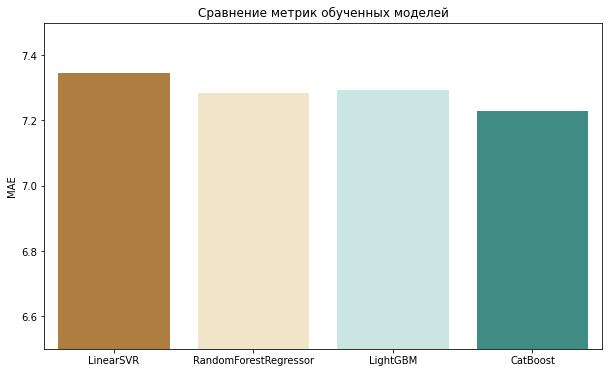

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=result.drop('DummyRegressor', axis=0), 
            y='MAE', x = list(result.drop('DummyRegressor', axis=0).index), 
            palette='BrBG')
plt.title('Сравнение метрик обученных моделей')
plt.ylim(6.5, 7.5)
plt.show()

>Лучший результат показала модель CatBoost с параметрами iterations=100, learning_rate=0.1, min_data_in_leaf=2, depth=2. Метрика MAE = 7.2305. Проверим результат на тестовой выборке. 

## Тестирование лучшей модели

In [ ]:
predicted = res_cat.predict(X_test)
print(f'MAE лучшей модели: {mean_absolute_error(y_test, predicted).round(4)}') 

MAE лучшей модели: 6.5341


> Лучшая модель показала результат на тестовой выборке 6.5341, что удовлетворяет условию заказчика, по которому метрика MAE должна быть <= 6.8.

### Анализ модели

> Посмотрим какие признаки оказали наибольшую важность при обучении модели:

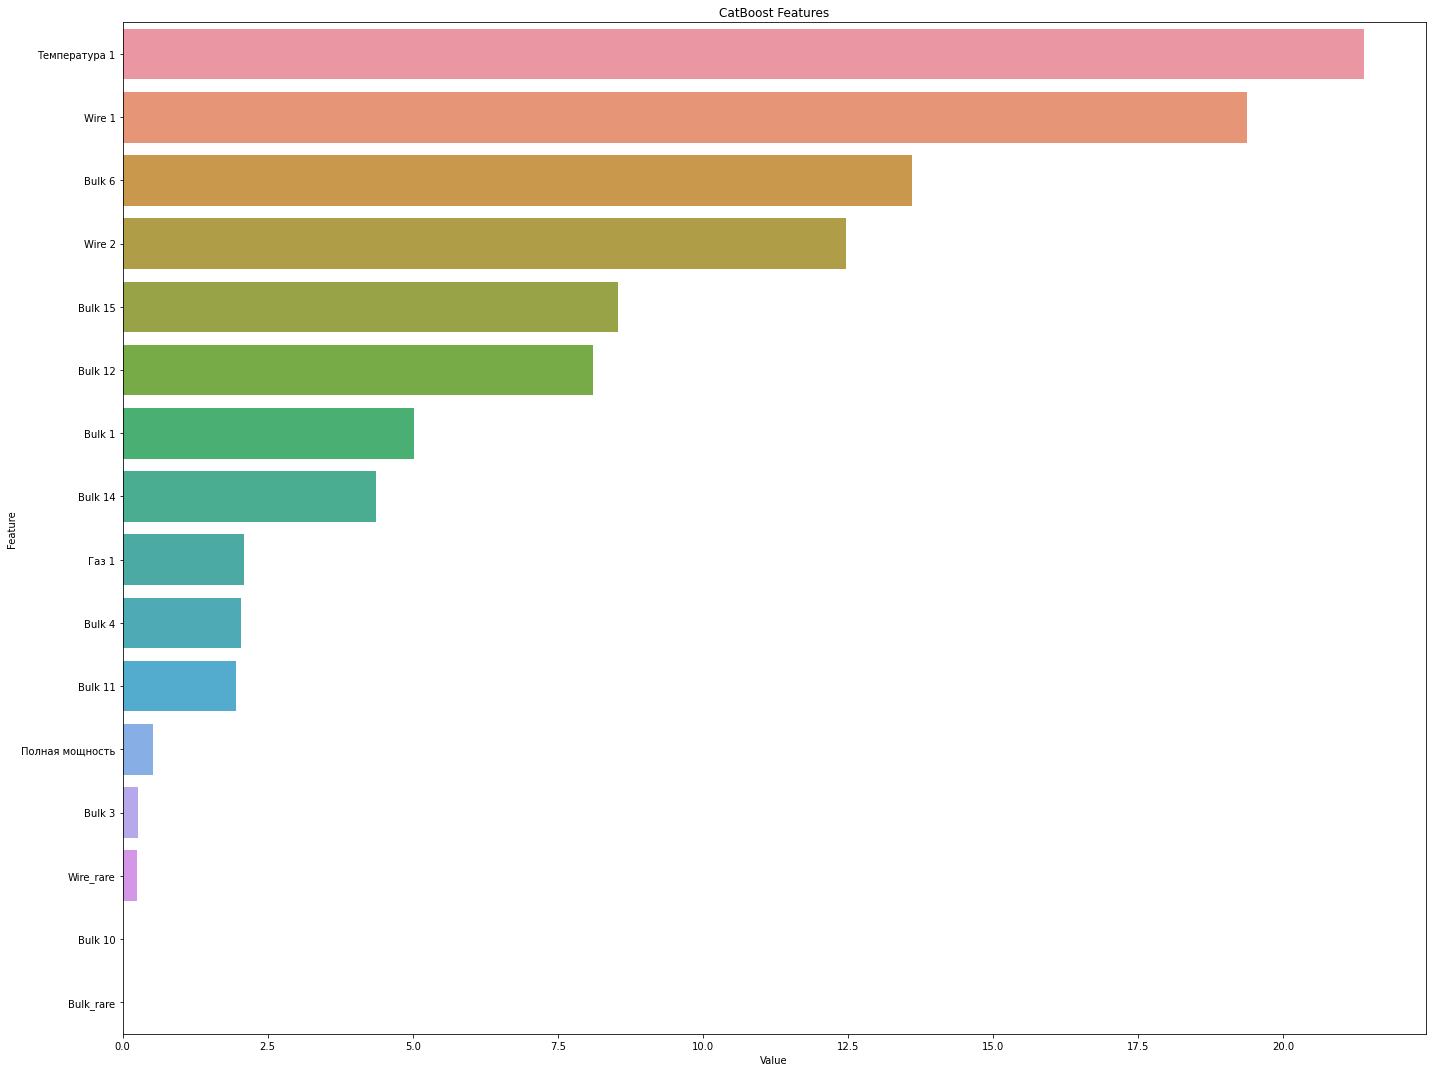

In [ ]:
try:
    feature_imp = pd.DataFrame(zip(res_cat[-1].feature_importances_,
                                          res_cat.named_steps["scaler"].get_feature_names_out()), 
                           columns=['Value','Feature'])
except:
        feature_imp = pd.DataFrame(zip(res_cat[-1].feature_importances_,
                                       X_train.columns), columns=['Value','Feature'])
plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('CatBoost Features')
plt.tight_layout()
plt.show()

Самыми важными признаками при прогнозировании температуры стали является первый замер температуры и объём добавки проволочного материала Wire 10. В следующую группу по влиянию на предсказания температуры можно выделить следующие 4 добавки - Wire 2 и  Bulk 6, 12, 15. 

Bulk 10 и объединенные редкие Bulk вообще не влияют на прогноз.

# РЕЗУЛЬТАТЫ ПРОЕКТА

<div style="border:solid blue 2px; padding: 20px">

В ходе работы над данным проектом было выполнено:
   -  Проведён аналих данных, изучена описательная статистика и общая информация каждой таблицы, обнаружены аномалии и пропуски. 
  
    С помощью боксплотов проверены на выбросы мощности, температура, подача газа и материалов (удалены аномальные значения и температуры выше 1400 градусов). Остальные выбросы оставили, так как после общения с заказчиком было выяснено, что такие значения иногда являются необходимыми во время производственного процесса.
    
  Также при анализе была изучена нормальность распределения: мощности и подача газа имеют отклонение вправо от нормального распределения, а распределение температуры стремится к нормальному.
    
  Пропуски в объёмах сыпучих и проволочных материалах заменены нулями, так как они говорят о том, что данный вид материалов не применялся при легировании стали в данной партии. Все партии, имеющие пропуски в таблице с температурами были уалены, потому что пропуски были только в последлних замерах (а это является нашей целевой), также удалены партии, имеющие только один замер.
   
    
   - Затем был выделен таргет и фичи, объединенные из разных таблиц по ключу партии. 
    Факторы, которые я отобрала для обучения модели: 
    
 * первый замер температуры;
 * объём подачи газа по партии;
 * присадки;
 * полная мощность.
   
    
   - После чего было разделение на обучающую и тренировочную выборки и проведено обучение 5 моделей (простейшая для проверки лучшей на адекватность, линейная регрессия опорных векторов LinearSVR; деревянная RandomForest и 2 модели градиентного бустинга (LightGBM и CatBoost). 
    
    Для обучения моделей была организована конвейерная обработка Pipeline, которая сначала масштабировала количественные признаки методом StandardScaler, а затем модель обучалась с помощью кросс-валидации, подбирая гиперпараметры через RandomizedSearchCV.
  
    
   - Результаты работы моделей были визуализированы с помощью графика барплот. Лучшую метрику MAE ранвую 7.2305 показала модель CatBoost, тестирование лучшей модели на тестовых данных показал резултат MAE = 6.5341, что удовлетворило результату задачи, по которой метрика должна быть менее 6.8.
    
    
   - В конце проекта был выведен график с важностью влияния признаков на работу нашей лучшей модели. Самыми важными признаками при прогнозировании температуры стали является первый замер температуры и объём добавки проволочного материала Wire 10. В следующую группу по влиянию на предсказания температуры можно выделить следующие 4 добавки - Wire 2 и  Bulk 6, 12, 15. 

   Bulk 10 и объединенные редкие Bulk вообще не влияют на прогноз.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>Предложение бизнесу:</b></u></p>
    <p>Если самым важным фактором является первая температура, то можно попытаться управлять энергозатратами, работая с этим признаком. Как вариант, установить границы допустимых значений температуры и фиксировать каждый выход за эти нормы. После чего, провести работу с отобранными случаями: <br>
 - выяснить какой материал и в какиз объемах подавался; <br>
 -  как проводилась продувка газом (объем и иные моменты); <br>
 - какие подавались мощности при нагреве графическими электродами. 

На базе полученных результатов, разработать энергосберегательные мероприятия.</p>
</div>